# **CA684 Machine Learning - Media Memorability**

## Predicting Media Memorability using various Machine Learning models and features.

**Task description:** The MediaEval's media memorability task focues on the memorability of videos. The aim of this project is to predict the capability of predicting how memorable a video can be.

## **Index**

**1. Importing the necessary libraries.**

**2. Defining all the functions needed for the analysis.**

**3. Loading the features needed for the analysis.**

**4.Exploring different models and features.**

**5. Final Predictions**
    








### **1. Importing all the necessary libraries.**

In [1]:
!pip install pyprind

In [2]:
import pandas as pd
import numpy as np
import pyprind
import matplotlib.pyplot as plt
import os
from keras import Sequential
from keras import layers
from keras import regularizers
from keras import preprocessing
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from sklearn.feature_extraction.text import HashingVectorizer

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

import tensorflow as tf
tf.__version__


Using TensorFlow backend.


'1.14.0'

## 2 Defining all the functions needed for the analysis.

**The following function will help us calculate the Spearman’s rank correlation between the predicted memorability scores
and the ground-truth memorability scores computed over all test
videos which is the evaluation metric.**

In [3]:
# Function to calculate the Spearman's Correlation Coefficient.

def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**The following function will load the captions and the labels.**

In [4]:
#Function to load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

**The following function will load the C3D features.**

In [5]:
#Function to load C3D features 

def read_C3D(fname): 
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()]
    return C3D

**The following function will load the Aesthetic features.**

In [6]:
#Function to load Aesthetic features 

def read_Aesthetic(fname):
    with open(fname) as f:
        for line in f:
            Aes =[item for item in line.split()]
    return Aes

## 3 Loading the features needed for the analysis.


**Loading Features from the Dev-set**

In [7]:
#Loading the captions from the dev set
caption_path = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Dev-Set/Captions/dev-set_video-captions.txt'#'./Dev-set/Captions/dev-set_video-captions.txt'
captions=read_caps(caption_path)

#Loadting the ground truth values from the dev set
ground_truth_path = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Dev-Set/Ground-truth/ground-truth.csv'
ground_truth=pd.read_csv(ground_truth_path)

In [8]:
#Printing out the loaded captions.
captions.head(2)

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot


In [9]:
#Printing out the loaded labels.
ground_truth.head(2)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12


In [10]:
##Loading the C3D Features
dir_C3D = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Dev-Set/C3D/' 
video = ground_truth.video.values

c3d = pd.DataFrame({'video': video,
                   'C3D': [read_C3D(dir_C3D+os.path.splitext(item)[0]+'.txt') for item in video],
                       })

In [11]:
#Printing out the C3D features.
c3d.head(2)

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."


In [12]:
c3d.shape


(6000, 2)

In [13]:
#Loading the Aesthetic Median Features
dir_aes_med = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Dev-Set/dev-set_aesthetic-features/features/aesthetic_visual_features/aesthetic_feat_dev-set_median/' 
video = ground_truth.video.values  #pull in video labels first

aes_med = pd.DataFrame({'video': video,
                   'Aesthetic_Median': [read_Aesthetic(dir_aes_med+os.path.splitext(item)[0]+'.txt') for item in video],
                       })

In [14]:
#Printing out the Aesthetic Median features.
aes_med.head()

,video,Aesthetic_Median
0,video3.webm,"[0.180874,0.715626,0.198930,0.610453,0.121610,..."
1,video4.webm,"[0.146076,0.550070,0.460729,0.424397,0.341807,..."
2,video6.webm,"[0.063898,0.827439,0.211925,0.720297,0.129499,..."
3,video8.webm,"[0.380539,0.134683,0.746891,0.171604,0.697045,..."
4,video10.webm,"[0.427258,0.381448,0.582746,0.409475,0.489531,..."


In [15]:
aes_med.shape

(6000, 2)

In [16]:
##Loading the Aesthetic Mean
dir_aes_mean = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Dev-Set/dev-set_aesthetic-features/features/aesthetic_visual_features/aesthetic_feat_dev-set_mean/' 
video = ground_truth.video.values

aes_mean = pd.DataFrame({'video': video,
                   'Aesthetic_Mean': [read_Aesthetic(dir_aes_mean+os.path.splitext(item)[0]+'.txt') for item in video],
                       })

In [17]:
#Printing out the Aesthetic Median features.
aes_mean.head(2)

,video,Aesthetic_Mean
0,video3.webm,"[0.183890,0.713733,0.202302,0.610132,0.124278,..."
1,video4.webm,"[0.147255,0.550718,0.460299,0.424981,0.341784,..."


In [18]:
aes_mean.shape

(6000, 2)

# 4.Exploring different models and features

### 4.1 CAPTIONS

**Preprocessing the data present in the captions**

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bidis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
captions.head(1)

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down


In [21]:
# Replace punctuations with space and convert words to lower case in captions
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(captions['caption']):
    
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    captions.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [22]:
captions.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [23]:
#Tokenization

def identify_tokens(row):
    review = row['caption']
    tokens = nltk.word_tokenize(review)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

captions['caption'] = captions.apply(identify_tokens, axis=1)
captions.head(2)

,video,caption
0,video3.webm,"[blonde, woman, is, massaged, tilt, down]"
1,video4.webm,"[roulette, table, spinning, with, ball, in, cl..."


In [24]:
#Stemming
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['caption']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

captions['caption'] = captions.apply(stem_list, axis=1)
captions.head(2)

,video,caption
0,video3.webm,"[blond, woman, is, massag, tilt, down]"
1,video4.webm,"[roulett, tabl, spin, with, ball, in, closeup,..."


In [25]:
#Removing the stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['caption']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

captions['caption'] = captions.apply(remove_stops, axis=1)
captions.head(2)

,video,caption
0,video3.webm,"[blond, woman, massag, tilt]"
1,video4.webm,"[roulett, tabl, spin, ball, closeup, shot]"


In [26]:
#Rejoining the words
def rejoin_words(row):
    my_list = row['caption']
    joined_words = ( " ".join(my_list))
    return joined_words

captions['caption'] = captions.apply(rejoin_words, axis=1)
captions.head(2)

,video,caption
0,video3.webm,blond woman massag tilt
1,video4.webm,roulett tabl spin ball closeup shot


 **Hashing Vectorizer**

In [27]:
vectorizer = HashingVectorizer(n_features=3112)
caption = vectorizer.fit_transform(captions['caption']).toarray()

In [28]:
caption.shape

(6000, 3112)

**4.1.1 Multilayer Perceptron**

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 2s 508us/step - loss: 0.3171 - accuracy: 0.6977 - val_loss: 0.2557 - val_accuracy: 0.7100
Epoch 2/10
4800/4800 [==============================] - 2s 382us/step - loss: 0.2179 - accuracy: 0.7033 - val_loss: 0.1825 - val_accuracy: 0.7100
Epoch 3/10
4800/4800 [==============================] - 2s 354us/step - loss: 0.1560 - accuracy: 0.7035 - val_loss: 0.1315 - val_accuracy: 0.7100
Epoch 4/10
4800/4800 [==============================] - 2s 362us/step - loss: 0.1131 - accuracy: 0.7035 - val_loss: 0.0960 - val_accuracy: 0.7100
Epoch 5/10
4800/4800 [==============================] - 2s 353us/step - loss: 0.0831 - accuracy: 0.7035 - val_loss: 0.0712 - val_accuracy: 0.7100
Epoch 6/10
4800/4800 [==============================] - 2s 370us/step - loss: 0.0621 - accuracy: 0.7035 - val_loss: 0.0540 - val_accuracy: 

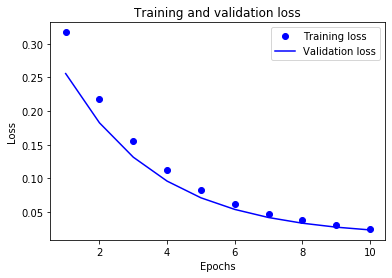

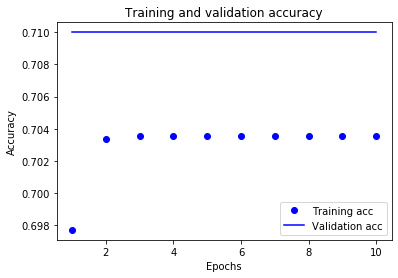

The Spearman's correlation coefficient is: 0.399
The Spearman's correlation coefficient is: 0.179


In [29]:
X = caption
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

model = Sequential() 
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0006),input_shape=(X.shape[1],))) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0006)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2,activation='sigmoid'))

# Compiling the model 
model.compile(optimizer='Adadelta',loss='mse',metrics=['accuracy'])

# Defining the early stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Training the model 
history = model.fit(X_train,Y_train,epochs=10,validation_data=(X_test, Y_test), callbacks= [early_stopping_monitor])

# Visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Y_prediction_val_MLP = model.predict(X_test)
Get_score(Y_prediction_val_MLP,Y_test)

**4.1.2 Bagging Regressor**

In [30]:
X = caption
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)


caption_br = BaggingRegressor(base_estimator = DecisionTreeRegressor(splitter = 'random'),n_estimators=100)
caption_br.fit(X_train,Y_train)

caption_br_prediction = caption_br.predict(X_test)
caption_br_prediction

Get_score(caption_br_prediction, Y_test)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.426
The Spearman's correlation coefficient is: 0.163


**4.1.3 Linear Regression**

In [31]:
X = caption
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

caption_lr = LinearRegression()
caption_lr.fit(X_train,Y_train)

caption_lr_prediction = caption_lr.predict(X_test)
caption_lr_prediction

Get_score(caption_lr_prediction, Y_test)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.238
The Spearman's correlation coefficient is: 0.119


# 4.2 C3D

In [32]:
c3d.head(2)

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."


In [33]:
#Splitting C3D column into individual rows
c3d1 = pd.DataFrame(c3d.C3D.apply(pd.Series))  
c3d1.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


**4.2.1 Multilayer Perceptron**

X_train  (4800, 101)
X_test   (1200, 101)
Y_train  (4800, 2)
Y_test   (1200, 2)
Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 1s 166us/step - loss: 0.1702 - accuracy: 0.6683 - val_loss: 0.1386 - val_accuracy: 0.7100
Epoch 2/10
4800/4800 [==============================] - 0s 93us/step - loss: 0.1225 - accuracy: 0.7035 - val_loss: 0.1061 - val_accuracy: 0.7100
Epoch 3/10
4800/4800 [==============================] - 0s 91us/step - loss: 0.0939 - accuracy: 0.7035 - val_loss: 0.0821 - val_accuracy: 0.7100
Epoch 4/10
4800/4800 [==============================] - 0s 95us/step - loss: 0.0732 - accuracy: 0.7035 - val_loss: 0.0644 - val_accuracy: 0.7100
Epoch 5/10
4800/4800 [==============================] - 0s 92us/step - loss: 0.0581 - accuracy: 0.7035 - val_loss: 0.0513 - val_accuracy: 0.7100
Epoch 6/10
4800/4800 [==============================] - 0s 94us/step - loss: 0.0464 - accuracy: 0.7035 - val_loss: 0.0416 - val_accuracy: 0.7100
E

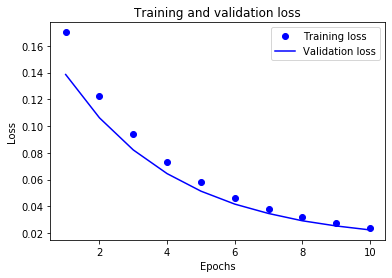

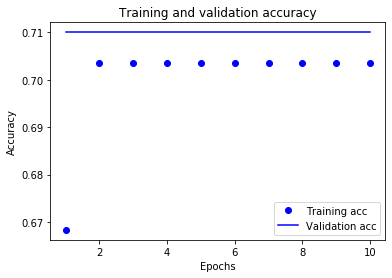

The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.127


In [34]:
X = c3d1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

model = Sequential() 
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2,activation='sigmoid'))

# Compiling the model 
model.compile(optimizer='Adadelta',loss='mse',metrics=['accuracy'])

# Defining the early stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

# Training the model 
history = model.fit(X_train,Y_train,epochs=10,validation_data=(X_test, Y_test), callbacks= [early_stopping_monitor])

# Visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

**4.2.2 Bagging Regressor**

In [35]:
X = c3d1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

c3d_br = BaggingRegressor(base_estimator = DecisionTreeRegressor(splitter = 'random'),n_estimators=100)
c3d_br.fit(X_train,Y_train)

c3d_br_prediction = c3d_br.predict(X_test)
c3d_br_prediction

Get_score(c3d_br_prediction, Y_test)

X_train  (4800, 101)
X_test   (1200, 101)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.316
The Spearman's correlation coefficient is: 0.104


**4.2.3 Linear Regression**

In [36]:
X = c3d1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

c3d_lr = LinearRegression()
c3d_lr.fit(X_train,Y_train)

c3d_lr_prediction = c3d_lr.predict(X_test)
c3d_lr_prediction

Get_score(c3d_lr_prediction, Y_test)

X_train  (4800, 101)
X_test   (1200, 101)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.277
The Spearman's correlation coefficient is: 0.103


# 4.3 Aesthetic median

In [37]:
aes_med.head(2)

,video,Aesthetic_Median
0,video3.webm,"[0.180874,0.715626,0.198930,0.610453,0.121610,..."
1,video4.webm,"[0.146076,0.550070,0.460729,0.424397,0.341807,..."


In [38]:
#Dropping the video column
aes_med1 = aes_med.drop('video',axis=1)  
aes_med1.head()

,Aesthetic_Median
0,"[0.180874,0.715626,0.198930,0.610453,0.121610,..."
1,"[0.146076,0.550070,0.460729,0.424397,0.341807,..."
2,"[0.063898,0.827439,0.211925,0.720297,0.129499,..."
3,"[0.380539,0.134683,0.746891,0.171604,0.697045,..."
4,"[0.427258,0.381448,0.582746,0.409475,0.489531,..."


In [39]:
#Splitting out Aesthetic Median column into individual rows
aes_med1 = pd.DataFrame(aes_med.Aesthetic_Median.apply(pd.Series)) 
aes_med1.rename(columns={0:'aes'}, inplace=True)
aes_med1=aes_med1.aes.apply(lambda x: pd.Series(str(x).split(",")))
aes_med1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.000000,...,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.000000,0.129661,0.412381,0.788761
1,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.000000,...,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.000000,0.692224,0.762354,-0.561793


**4.3.1 Multilayer Perceptron**

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 199us/step - loss: 0.2078 - accuracy: 0.6831 - val_loss: 0.1843 - val_accuracy: 0.7100
Epoch 2/20
4800/4800 [==============================] - 1s 119us/step - loss: 0.1662 - accuracy: 0.7008 - val_loss: 0.1521 - val_accuracy: 0.7100
Epoch 3/20
4800/4800 [==============================] - 1s 123us/step - loss: 0.1379 - accuracy: 0.7017 - val_loss: 0.1273 - val_accuracy: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 120us/step - loss: 0.1156 - accuracy: 0.7019 - val_loss: 0.1078 - val_accuracy: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 118us/step - loss: 0.0987 - accuracy: 0.7015 - val_loss: 0.0933 - val_accuracy: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 126us/step - loss: 0.0857 - accuracy: 0.7019 - val_loss: 0.0819 - val_accuracy: 0.7

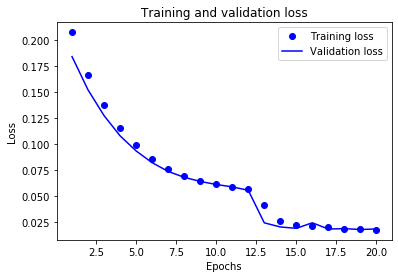

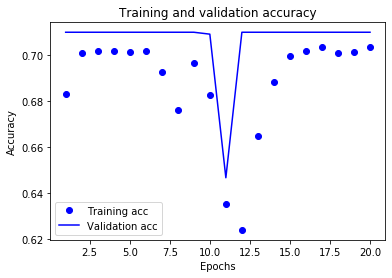

The Spearman's correlation coefficient is: 0.053
The Spearman's correlation coefficient is: 0.057


In [40]:
X = aes_med1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

model = Sequential() 
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(X.shape[1],))) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2,activation='sigmoid'))

# Compiling the model 
model.compile(optimizer='Adadelta',loss='mse',metrics=['accuracy'])

# Defining the early stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

# Training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test, Y_test), callbacks= [early_stopping_monitor])

# Visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

**4.3.2 Bagging Regressor**

In [41]:
X = aes_med1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

aes_med_br = BaggingRegressor(base_estimator = DecisionTreeRegressor(splitter = 'random'),n_estimators=100)
aes_med_br.fit(X_train,Y_train)

aes_med_br_prediction = aes_med_br.predict(X_test)
aes_med_br_prediction

Get_score(aes_med_br_prediction, Y_test)

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.288
The Spearman's correlation coefficient is: 0.104


**4.3.3 Linear Regression**

In [42]:
X = aes_med1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

aes_med_lr = LinearRegression()
aes_med_lr.fit(X_train,Y_train)

aes_med_lr_prediction = aes_med_lr.predict(X_test)
aes_med_lr_prediction

Get_score(aes_med_lr_prediction, Y_test)

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.271
The Spearman's correlation coefficient is: 0.111


# 4.4 Aesthetic Mean

In [43]:
aes_mean.head(2)

,video,Aesthetic_Mean
0,video3.webm,"[0.183890,0.713733,0.202302,0.610132,0.124278,..."
1,video4.webm,"[0.147255,0.550718,0.460299,0.424981,0.341784,..."


In [44]:
#Removing the video column
aes_mean1 = aes_mean.drop('video',axis=1) 
aes_mean1.head()

,Aesthetic_Mean
0,"[0.183890,0.713733,0.202302,0.610132,0.124278,..."
1,"[0.147255,0.550718,0.460299,0.424981,0.341784,..."
2,"[0.063933,0.826933,0.214129,0.719341,0.130606,..."
3,"[0.367527,0.133869,0.746074,0.169317,0.696747,..."
4,"[0.402878,0.389358,0.564687,0.400378,0.471548,..."


In [45]:
#Splitting out Aesthetic_Mean column into individual rows
aes_mean1 = pd.DataFrame(aes_mean.Aesthetic_Mean.apply(pd.Series)) 
aes_mean1.rename(columns={0:'aes'}, inplace=True)
aes_mean1=aes_mean1.aes.apply(lambda x: pd.Series(str(x).split(",")))
aes_mean1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,0.183890,0.713733,0.202302,0.610132,0.124278,0.691408,54.980466,0.098504,0.000973,2.000000,...,0.001727,-0.002716,0.290079,0.295183,0.352099,0.570387,0.000000,3.787912,0.236836,0.748159
1,0.147255,0.550718,0.460299,0.424981,0.341784,0.397867,47.395202,0.119074,0.002255,2.000000,...,-0.000572,-0.000242,0.700697,0.302694,0.378382,0.795025,0.000000,0.951803,-0.682860,-2.001414


**4.4.1 Multilayer Perceptron**

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 202us/step - loss: 0.2197 - accuracy: 0.6869 - val_loss: 0.1871 - val_accuracy: 0.7100
Epoch 2/20
4800/4800 [==============================] - 1s 122us/step - loss: 0.1709 - accuracy: 0.7013 - val_loss: 0.1562 - val_accuracy: 0.7100
Epoch 3/20
4800/4800 [==============================] - 1s 129us/step - loss: 0.1417 - accuracy: 0.6977 - val_loss: 0.1310 - val_accuracy: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 121us/step - loss: 0.1193 - accuracy: 0.6996 - val_loss: 0.1113 - val_accuracy: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 122us/step - loss: 0.1021 - accuracy: 0.6992 - val_loss: 0.0964 - val_accuracy: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 124us/step - loss: 0.0890 - accuracy: 0.6963 - val_loss: 0.0850 - val_accuracy: 0.7

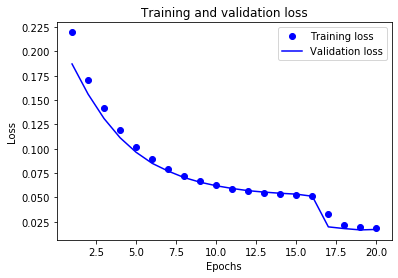

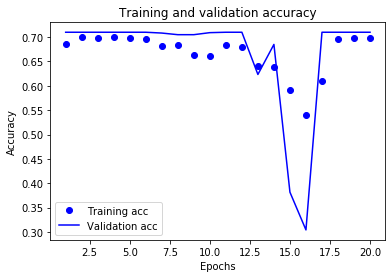

The Spearman's correlation coefficient is: 0.126
The Spearman's correlation coefficient is: 0.063


In [46]:
X = aes_mean1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

model = Sequential()
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(X.shape[1],))) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2,activation='sigmoid'))

# Compiling the model 
model.compile(optimizer='Adadelta',loss='mse',metrics=['accuracy'])

# Defining the early stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

# Training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test, Y_test), callbacks= [early_stopping_monitor])

# Visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

**4.4.2 Bagging Regressor**

In [47]:
X = aes_mean1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

aes_mean_br = BaggingRegressor(base_estimator = DecisionTreeRegressor(splitter = 'random'),n_estimators=100)
aes_mean_br.fit(X_train,Y_train)

aes_mean_br_prediction = aes_mean_br.predict(X_test)
aes_mean_br_prediction

Get_score(aes_mean_br_prediction, Y_test)

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.286
The Spearman's correlation coefficient is: 0.112


**4.4.3 Linear Regression**

In [48]:
X = aes_mean1.values
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', Y_train.shape)
print('Y_test  ', Y_test.shape)

aes_mean_lr = LinearRegression()
aes_mean_lr.fit(X_train,Y_train)

aes_mean_prediction = aes_mean_lr.predict(X_test)
aes_mean_prediction

Get_score(aes_mean_prediction, Y_test)

X_train  (4800, 109)
X_test   (1200, 109)
Y_train  (4800, 2)
Y_test   (1200, 2)
The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.124


**Results of Testing**

From all the features tested,we see that the Captions with the Bagging Regressor gives us the best Spearman Scores in terms of the short-term scores and a combination of Captions and Multilayered Perceptron gives us the best long-term scores. 

In [49]:
#Captions and Bagging Regressor
Get_score(caption_br_prediction, Y_test)

The Spearman's correlation coefficient is: 0.426
The Spearman's correlation coefficient is: 0.163


In [50]:
#Captions and MLP
Get_score(Y_prediction_val_MLP,Y_test)

The Spearman's correlation coefficient is: 0.399
The Spearman's correlation coefficient is: 0.179


The long-term predictions are comparable for both the models but there is a large difference in the short-term scores. Therefore, for the predictions on the test set, I will be using the Bagging Regressor along with Captions.

# 5. Final Predictions

**Loading Test-Set features**

In [51]:
#Loading the captions from the test set
caption_path_test = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Test-Set/Captions_test/test-set-1_video-captions.txt'
captions_test=read_caps(caption_path_test)

In [52]:
#Printing out the loaded captions.
captions_test.head(2)

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...


In [53]:
captions_test.shape

(2000, 2)

In [54]:
# Replace punctuations with space and convert words to lower case in captions_test
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(captions_test['caption']), title='Counting word occurrences')
for i, cap in enumerate(captions_test['caption']):
    
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    captions_test.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

captions_test.head(2)    

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,video,caption
0,video7494.webm,green jeep struggling to drive over huge rocks
1,video7495.webm,hiking woman tourist is walking forward in mou...


In [55]:
#Tokenization

def identify_tokens(row):
    review = row['caption']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

captions_test['caption'] = captions_test.apply(identify_tokens, axis=1)
captions_test.head(2)

,video,caption
0,video7494.webm,"[green, jeep, struggling, to, drive, over, hug..."
1,video7495.webm,"[hiking, woman, tourist, is, walking, forward,..."


In [56]:
#Stemming
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['caption']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

captions_test['caption'] = captions_test.apply(stem_list, axis=1)
captions_test.head(2)

,video,caption
0,video7494.webm,"[green, jeep, struggl, to, drive, over, huge, ..."
1,video7495.webm,"[hike, woman, tourist, is, walk, forward, in, ..."


In [57]:
#Removing the stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['caption']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

captions_test['caption'] = captions_test.apply(remove_stops, axis=1)
captions_test.head(2)

,video,caption
0,video7494.webm,"[green, jeep, struggl, drive, huge, rock]"
1,video7495.webm,"[hike, woman, tourist, walk, forward, mountain..."


In [58]:
#Rejoining the words
def rejoin_words(row):
    my_list = row['caption']
    joined_words = ( " ".join(my_list))
    return joined_words

captions_test['caption'] = captions_test.apply(rejoin_words, axis=1)
captions_test.head(2)

,video,caption
0,video7494.webm,green jeep struggl drive huge rock
1,video7495.webm,hike woman tourist walk forward mountain sunse...


**Hashing Vectorizer**

In [59]:
vectorizer = HashingVectorizer(n_features=3112)
caption_test = vectorizer.fit_transform(captions_test['caption']).toarray()

In [60]:
caption_test.shape

(2000, 3112)

In [61]:
caption.shape

(6000, 3112)

**Training on the dev-set**

In [62]:
X = caption
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

print('X_train ', X.shape)
print('Y_train ', Y.shape)

model = BaggingRegressor(base_estimator = DecisionTreeRegressor(splitter = 'random'),n_estimators=100)
model.fit(X,Y)


X_train  (6000, 3112)
Y_train  (6000, 2)


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='random'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samp

**Predicting the short term and long term meorability values on the test-set.**

In [63]:
Y_prediction_val = model.predict(caption_test)
Y_prediction_val

array([[0.8848325 , 0.79134   ],
       [0.75125856, 0.78156255],
       [0.9146225 , 0.82001167],
       ...,
       [0.89213167, 0.80680333],
       [0.90042567, 0.83009833],
       [0.88202   , 0.83108   ]])

In [64]:
Y_prediction_val.shape

(2000, 2)

**Exporting the predicted values to a csv**

In [65]:
np.savetxt("D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/predictions.csv", Y_prediction_val, delimiter = ",",header="short-term_memorability,long-term_memorability",comments='')

In [66]:
#Loadting the ground truth values from the test set
ground_truth_path_test = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Datasets/Test-Set/Ground-truth_test/ground_truth_template.csv'
ground_truth_test=pd.read_csv(ground_truth_path_test)

In [67]:
ground_truth_test.head(2)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10


In [68]:
ground_truth_test.shape

(2000, 5)

In [69]:
captions_test.shape

(2000, 2)

In [70]:
captions_test.head(2)

,video,caption
0,video7494.webm,green jeep struggl drive huge rock
1,video7495.webm,hike woman tourist walk forward mountain sunse...


In [71]:
#Loading the predicted values
predictions_path = 'D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/predictions.csv'
df=pd.read_csv(predictions_path)

In [72]:
df.head(2)

,short-term_memorability,long-term_memorability
0,0.884832,0.791340
1,0.751259,0.781563


In [73]:
df.shape

(2000, 2)

We see that there are 2000 predicted values. This means that, we have trained on the whole dev-set and have predicted the short-term and long-term memorability values of the test-set.

In [74]:
#Adding the predicted values to the ground truth values
ground_truth_test['short-term_memorability'] = df['short-term_memorability']
ground_truth_test['long-term_memorability'] = df['long-term_memorability']
ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.884832,33,0.791340,12
1,7495,0.751259,34,0.781563,10
2,7496,0.914623,32,0.820012,13
3,7497,0.889209,33,0.811513,10
4,7498,0.835912,33,0.723598,10


In [75]:
#Exporting the final ground truth values as a csv file
ground_truth_test.to_csv("D:/DCU/2nd Semester/CA684 - Machine Learning/Assignment/Solution/Final Predictions.csv")